<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment23/assignment23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all python packages

In [0]:
import dlib
import cv2
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [0]:
# Landmark model location
PREDICTOR_PATH_5PT = "shape_predictor_5_face_landmarks.dat"
PREDICTOR_PATH_68PT = "shape_predictor_68_face_landmarks.dat"

In [0]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector_5pt = dlib.shape_predictor(PREDICTOR_PATH_5PT)
landmarkDetector_68pt = dlib.shape_predictor(PREDICTOR_PATH_68PT)

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = predict[36]
  rightEyeRightCorner = predict[45]
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

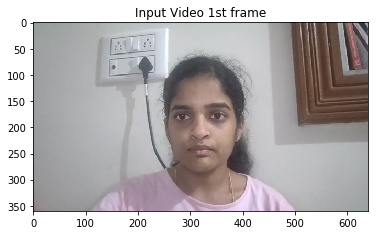

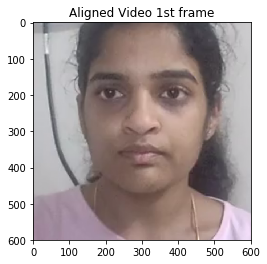

242


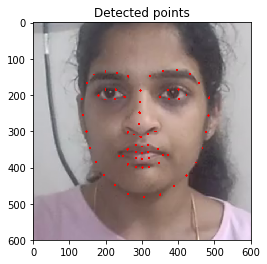

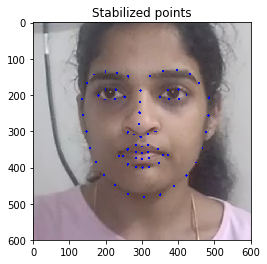

Can't receive frame (stream end?). Exiting ...


In [0]:
from google.colab.patches import cv2_imshow
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('aligned.264', fourcc, 20.0, (600,  600))
cap = cv2.VideoCapture('assignment23_input.mp4')
out1 = cv2.VideoWriter('detected.264', fourcc, 20.0, (600,  600))
out2 = cv2.VideoWriter('stabilized.264', fourcc, 20.0, (600,  600))


winSize = 101
maxLevel = 10
fps = 30.0
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]
eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False

while cap.isOpened():
  
    #read input frame from video
    
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
                
    if (isFirstFrame==True):
      plt.imshow(frame[:,:,::-1])
      plt.title("Input Video 1st frame")
      plt.show()
      
    h = 600
    w = 600
      
   # Determine 5-point landmark of the face
    
    face_5_pts = fbc.getLandmarks(faceDetector, landmarkDetector_5pt, frame)
    face_5_pts = np.array(face_5_pts)
    im = np.float32(frame)/255.0
    
    
    # Align the face to center using the 5-pt landmark points. Normalize image to output coordinates
    
    imNorm, face_5_pts = fbc.normalizeImagesAndLandmarks((h, w), im, face_5_pts)
    imNorm = np.uint8(imNorm*255)
    
    if (isFirstFrame==True):
      plt.imshow(imNorm[:,:,::-1])
      plt.title("Aligned Video 1st frame")
      plt.show() 
    
    out.write(imNorm)
    
    size = imNorm.shape[0:1]
    imGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Get 68-point landmark required for tracking face
    
    face_68_pts = fbc.getLandmarks(faceDetector, landmarkDetector_68pt, imNorm)
    
 
    # Handling the first frame of video differently,for the first frame copy the current frame points
      
    if (isFirstFrame==True):
      pointsPrev=[]
      pointsDetectedPrev = []
      [pointsPrev.append(p) for p in face_68_pts]
      [pointsDetectedPrev.append(p) for p in face_68_pts]
      imGrayPrev = imGray

    # If not the first frame, copy points from previous frame.
    else:
      pointsPrev=[]
      pointsDetectedPrev = []
      pointsPrev = points
      pointsDetectedPrev = pointsDetectedCur

    # pointsDetectedCur stores results returned by the facial landmark detector
    # points stores the stabilized landmark points
    points = []
    pointsDetectedCur = []
    [points.append(p) for p in face_68_pts]
    [pointsDetectedCur.append(p) for p in face_68_pts]

    # Convert to numpy float array
    pointsArr = np.array(points,np.float32)
    pointsPrevArr = np.array(pointsPrev,np.float32)

    # If eye distance is not calculated before
    if eyeDistanceNotCalculated:
      eyeDistance = interEyeDistance(face_68_pts)
      print(eyeDistance)
      eyeDistanceNotCalculated = False

    if eyeDistance > 100:
        dotRadius = 3
    else:
      dotRadius = 2

    sigma = eyeDistance * eyeDistance / 400
    s = 2*int(eyeDistance/4)+1

    #  Set up optical flow params
    lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
    # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
    # ret, imGrayPyr= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)

    pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)


    # Converting to float
    pointsArrFloat = np.array(pointsArr,np.float32)

    # Converting back to list
    points = pointsArrFloat.tolist()

    # Final landmark points are a weighted average of
    # detected landmarks and tracked landmarks
    for k in range(0,len(face_68_pts)):
      d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
      alpha = math.exp(-d*d/sigma)
      points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

    stabilized = copy.copy(imNorm)
    
    for p in pointsDetectedCur:
      cv2.circle(imNorm,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)
      
    if (isFirstFrame==True):
      plt.imshow(imNorm[:,:,::-1])
      plt.title("Detected points")
      plt.show()
      
    out1.write(imNorm)
   
    for p in points:
      cv2.circle(stabilized,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)

    if (isFirstFrame==True):
      plt.imshow(stabilized[:,:,::-1])
      plt.title("Stabilized points")
      plt.show()
      
    out2.write(stabilized)
      
    isFirstFrame = False

    # Getting ready for next frame
    imPrev = imNorm
    imGrayPrev = imGray
    
    
cap.release()
cv2.destroyAllWindows()
out.release()
out1.release()
out2.release()